# Fine-tuning MusicGen for Under-represented Music Genres and Instruments

This project focuses on fine-tuning Meta’s **MusicGen model** to generate music for under-represented genres and instruments for ethnically diverse music like Indian classical fusion for example, addressing data scarcity and improving stylistic diversity in AI-driven music.


[MusicGen](https://audiocraft.metademolab.com/musicgen.html) is a state-of-the-art controllable text-to-music model, made of a single stage auto-regressive Transformer model trained over a 32kHz [Encodec](https://huggingface.co/facebook/encodec_32khz) tokenizer with 4 codebooks sampled at 50 Hz.

## Prepare the Environment

In [ ]:
# !pip install --quiet git+https://github.com/ylacombe/musicgen-dreamboothing demucs msclap
# !pip install -U git+https://github.com/huggingface/transformers

## Loading the dataset

- The model expects audio files around 15-30 seconds at a sample rate of 32kHz. We have created our custom dataset for fine-tuning different models.
- The tracks are all segmented into 30 second or lesser chunks and split into train and test split at a ratio of 10:1. (chunkmusic.py)
- A dataframe is created using the script preprocess_data.py that contains the full paths to each audio file and is loaded using the datasets library

In [4]:
# Load your custom dataset
from datasets import load_from_disk

# Load the dataset you created
dataset = load_from_disk("music_data/anoushka-sharma-traes-dataset/dataset")

# If you want to use only the training split
dataset = dataset["train"]

# Display a few samples from the dataset
for i in range(min(3, len(dataset))):
    print(f"\nSample {i+1}:")
    print(f"File name: {dataset[i]['file_name']}")
    print(f"Audio path: {dataset[i]['audio']['path']}")
    print(f"Audio sampling rate: {dataset[i]['audio']['sampling_rate']}")
    print(f"Audio shape: {dataset[i]['audio']['array'].shape}")

/mnt/d/conda/envs/musicgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Sample 1:
File name: Anoushka Shankar - In Jyoti's Name_chunk006.mp3
Audio path: Anoushka Shankar - In Jyoti's Name_chunk006.mp3
Audio sampling rate: 32000
Audio shape: (960000,)

Sample 2:
File name: Anoushka Shankar - Chasing Shadows_chunk001.mp3
Audio path: Anoushka Shankar - Chasing Shadows_chunk001.mp3
Audio sampling rate: 32000
Audio shape: (960000,)

Sample 3:
File name: Anoushka Shankar - In Jyoti's Name_chunk007.mp3
Audio path: Anoushka Shankar - In Jyoti's Name_chunk007.mp3
Audio sampling rate: 32000
Audio shape: (960000,)


Listen to an example from the loaded dataset

In [5]:
from IPython.display import Audio

Audio(dataset[0]["audio"]["array"], rate=dataset[0]["audio"]["sampling_rate"])

# Preprocessing dataset 

### 1. Vocal removal
MusicGen was trained only on instrumental music and hence cannot be trained on tracks with vocals. To tackle this, we use [demucs](https://github.com/adefossez/demucs/tree/main) which is a source separation model, to separate and remove vocals from tracks

**Note**: This step is not necessary if you have tracks that have no vocals present in them.


In [ ]:
# Load and prepare Demucs for audio source separation
from demucs import pretrained
from demucs.apply import apply_model
from demucs.audio import convert_audio
from datasets import Audio
import torch

# Load the Demucs HT model
demucs = pretrained.get_model("htdemucs")

# GPU Acceleration
if torch.cuda.device_count() > 0:
    demucs.to("cuda:0")
    
audio_column_name = "audio"

In [ ]:
# Function to convert audio tensors back to standard format compatible with the Dataset
def wrap_audio(audio, sr):
    """Wrap audio tensor into a dictionary with array and sampling rate keys."""
    return {"array": audio.cpu().numpy(), "sampling_rate": sr}

# Process each batch of audio with Demucs to filter/enhance specific instrumental parts
def filter_stems(batch, rank=None):
    """Apply source separation to extract and process audio stems."""
    # Choose the appropriate device (GPU or CPU)
    device = "cpu" if torch.cuda.device_count() == 0 else "cuda:0"

    # Convert each audio sample to the format expected by Demucs
    wavs = [
        convert_audio(
            torch.tensor(audio["array"][None], device=device).to(
                torch.float32
            ),
            audio["sampling_rate"],
            demucs.samplerate,  # Target sample rate for Demucs (usually 44.1kHz)
            demucs.audio_channels,  # Target channel count
        ).T
        for audio in batch["audio"]
    ]
    # Store original lengths for later reconstruction
    wavs_length = [audio.shape[0] for audio in wavs]

    # Pad sequences to same length for batch processing
    wavs = torch.nn.utils.rnn.pad_sequence(
        wavs, batch_first=True, padding_value=0.0
    ).transpose(1, 2)
    
    # Apply Demucs model to separate audio into stems
    stems = apply_model(demucs, wavs)

    # Process the separated stems:
    batch[audio_column_name] = [
        wrap_audio(s[:-1, :, :length].sum(0).mean(0), demucs.samplerate)
        for (s, length) in zip(stems, wavs_length)
    ]

    return batch

# Number of parallel processes for dataset mapping
num_proc = 1

# Apply the stem filtering to the entire dataset
dataset = dataset.map(
    filter_stems,
    batched=True,        
    batch_size=8,        # Number of samples per batch
    with_rank=True,      
    num_proc=num_proc,   # Number of parallel processes
)

# Update the audio column type to ensure proper handling
dataset = dataset.cast_column(audio_column_name, Audio())

# Free up GPU memory by removing the Demucs model
del demucs

# Save the processed dataset to disk for later use
dataset.save_to_disk("/mnt/f/SMC/CMC/musicgen-dreamboothing/processed_data/as-ch3-data/processed_dataset")

print("Processing complete!")
print(f"Processed audio saved")
print(f"Processed dataset saved")

Saving the dataset (1/1 shards): 100%|██████████| 187/187 [00:04<00:00, 41.96 examples/s]

Processing complete!
Processed audio saved to: /mnt/f/SMC/CMC/musicgen-dreamboothing/processed_audio
Processed dataset saved to: /mnt/f/SMC/CMC/musicgen-dreamboothing/processed_dataset


In this step we:
- load the demucs model
- define a function to apply it to a batch of samples and filter out vocals

Listen to filtered audio:

In [ ]:
# Load the processed dataset
from datasets import load_from_disk
processed_dataset = load_from_disk("/mnt/f/SMC/CMC/musicgen-dreamboothing/processed_data/as-ch3-data/processed_dataset")

In [ ]:
# Display sample audio
from IPython.display import Audio
Audio(processed_dataset[5]["audio"]["array"], rate=dataset[0]["audio"]["sampling_rate"])

## 2. Labeling the dataset (Metadata embeddings)


The previous step was mandatory, but the dataset is still missing some music description.

We use **Librosa** in order to get the tempo(bpm) and key of the music in the dataset and extract **CLAP** embeddings to get the genre, instruments and mood

In [7]:
from utils import instrument_classes, genre_labels, mood_theme_classes
print("Genres", genre_labels)
print("Instruments:", instrument_classes)
print("Moods", mood_theme_classes)

Genres ['Blues, Boogie Woogie', 'Blues, Chicago Blues', 'Blues, Country Blues', 'Blues, Delta Blues', 'Blues, Electric Blues', 'Blues, Harmonica Blues', 'Blues, Jump Blues', 'Blues, Louisiana Blues', 'Blues, Modern Electric Blues', 'Blues, Piano Blues', 'Blues, Rhythm & Blues', 'Blues, Texas Blues', 'Brass & Military, Brass Band', 'Brass & Military, Marches', 'Brass & Military, Military', "Children's, Educational", "Children's, Nursery Rhymes", "Children's, Story", 'Classical, Baroque', 'Classical, Choral', 'Classical, Classical', 'Classical, Contemporary', 'Classical, Impressionist', 'Classical, Medieval', 'Classical, Modern', 'Classical, Neo-Classical', 'Classical, Neo-Romantic', 'Classical, Opera', 'Classical, Post-Modern', 'Classical, Renaissance', 'Classical, Romantic', 'Electronic, Abstract', 'Electronic, Acid', 'Electronic, Acid House', 'Electronic, Acid Jazz', 'Electronic, Ambient', 'Electronic, Bassline', 'Electronic, Beatdown', 'Electronic, Berlin-School', 'Electronic, Big Be

In [ ]:
# Import necessary libraries for audio analysis and embedding extraction
from msclap import CLAP
import torch
import librosa
import tempfile
import torchaudio
import random
import numpy as np
import os
import gc

# Initialize the CLAP model for audio-text similarity analysis
clap_model = CLAP(version="2023", use_cuda=True)  # Use GPU acceleration if available

# Generate text embeddings for different musical attributes
instrument_embeddings = clap_model.get_text_embeddings(instrument_classes)  # Embeddings for different instruments
genre_embeddings = clap_model.get_text_embeddings(genre_labels)  # Embeddings for different music genres
mood_embeddings = clap_model.get_text_embeddings(mood_theme_classes)  # Embeddings for different moods/themes

In [ ]:
def enrich_text(batch):
    # Extract audio data and sampling rate from the batch
    audio, sampling_rate = (
        batch["audio"]["array"],
        batch["audio"]["sampling_rate"],
    )
    
    # Detect tempo (beats per minute) using librosa
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sampling_rate)
    if isinstance(tempo, np.ndarray):
        tempo = float(tempo[0]) if tempo.size > 0 else 120.0
    tempo = f"{int(round(tempo))} bpm"
    
    # Detect musical key using chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sampling_rate)
    key = np.argmax(np.sum(chroma, axis=1))
    key = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"][key]

    # Create audio embeddings using CLAP model
    with tempfile.TemporaryDirectory() as tempdir:
        path = os.path.join(tempdir, "tmp.wav")
        torchaudio.save(path, torch.tensor(audio).unsqueeze(0), sampling_rate)
        audio_embeddings = clap_model.get_audio_embeddings([path])

    # Match audio with instrument, genre and mood using similarity scores
    instrument = instrument_classes[clap_model.compute_similarity(
        audio_embeddings, instrument_embeddings
    ).argmax(dim=1)[0]]
    
    genre = genre_labels[clap_model.compute_similarity(
        audio_embeddings, genre_embeddings
    ).argmax(dim=1)[0]]
    
    mood = mood_theme_classes[clap_model.compute_similarity(
        audio_embeddings, mood_embeddings
    ).argmax(dim=1)[0]]

    # Combine all metadata and randomize order
    metadata = [key, tempo, instrument, genre, mood]
    random.shuffle(metadata)
    batch["metadata"] = ", ".join(metadata)
    return batch

# Apply metadata enrichment to each audio sample
dataset = dataset.map(
    enrich_text,
    desc="add metadata",
)

# Free memory by removing the large models
del clap_model, instrument_embeddings, genre_embeddings, mood_embeddings

# Save enriched dataset to disk
output_dir = "processed_data/as-traes-data/processed_dataset_meta"
os.makedirs(output_dir, exist_ok=True)
dataset.save_to_disk(output_dir)
print(f"Saved enriched dataset to: {output_dir}")

Saving the dataset (1/1 shards): 100%|██████████| 70/70 [00:01<00:00, 67.41 examples/s]

Saved enriched dataset to: processed_data/as-traes-data/processed_dataset_meta


### Optional : To handle larger datasets

In order to handle larger datasets that demand greater computational resources, the following cells perform the CLAP metadata extraction by segmenting the dataset into smaller chunks for efficient processing.

(uncollapse to use them)

In [11]:
def enrich_text_with_fallback(batch):
    results = []
    
    for i in range(len(batch["audio"])):
        try:
            # Process one sample at a time
            audio = batch["audio"][i]["array"]
            sampling_rate = batch["audio"][i]["sampling_rate"]
            
            # Calculate tempo
            try:
                tempo, _ = librosa.beat.beat_track(y=audio, sr=sampling_rate)
                if isinstance(tempo, np.ndarray):
                    tempo = float(tempo[0]) if tempo.size > 0 else 120.0
                tempo = f"{int(round(tempo))} bpm"
            except Exception as e:
                print(f"Tempo calculation error: {e}")
                tempo = "120 bpm"  # Default fallback
            
            # Calculate key
            try:
                chroma = librosa.feature.chroma_stft(y=audio, sr=sampling_rate)
                key = np.argmax(np.sum(chroma, axis=1))
                key = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"][key]
            except Exception as e:
                print(f"Key calculation error: {e}")
                key = "C"  # Default fallback
            
            # CLAP model processing
            try:
                with tempfile.TemporaryDirectory() as tempdir:
                    path = os.path.join(tempdir, "tmp.wav")
                    torchaudio.save(path, torch.tensor(audio).unsqueeze(0), sampling_rate)
                    audio_embeddings = clap_model.get_audio_embeddings([path])
                
                instrument = clap_model.compute_similarity(
                    audio_embeddings, instrument_embeddings
                ).argmax(dim=1)[0]
                genre = clap_model.compute_similarity(
                    audio_embeddings, genre_embeddings
                ).argmax(dim=1)[0]
                mood = clap_model.compute_similarity(
                    audio_embeddings, mood_embeddings
                ).argmax(dim=1)[0]
                
                instrument = instrument_classes[instrument]
                genre = genre_labels[genre]
                mood = mood_theme_classes[mood]
            except Exception as e:
                print(f"CLAP model error: {e}")
                instrument = "guitar"  # Default fallbacks
                genre = "rock"
                mood = "energetic"
            
            # Combine metadata
            metadata = [key, tempo, instrument, genre, mood]
            random.shuffle(metadata)
            metadata_str = ", ".join(metadata)
            
            # Clear memory
            if i % 5 == 0:  # Garbage collect every 5 samples
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            metadata_str = "C, 120 bpm, guitar, rock, energetic"  # Default fallback
        
        results.append(metadata_str)
    
    batch["metadata"] = results
    return batch

# Process in very small batches to avoid memory issues
batch_size = 1

# Split processing into chunks to avoid memory overflow
processed_dataset_with_metadata = dataset
for chunk_start in range(0, len(dataset), 50):
    chunk_end = min(chunk_start + 50, len(dataset))
    print(f"Processing chunk {chunk_start} to {chunk_end}...")
    
    # Get the chunk of data
    chunk = dataset.select(range(chunk_start, chunk_end))
    
    # Process the chunk
    chunk = chunk.map(
        enrich_text_with_fallback,
        batched=True,
        batch_size=batch_size,
        desc=f"Adding metadata (samples {chunk_start}-{chunk_end})",
    )
    
    # Save the intermediate results
    chunk_path = f"/mnt/f/SMC/CMC/musicgen-dreamboothing/processed_chunks_as/processed_metadata_chunk_{chunk_start}_{chunk_end}"
    chunk.save_to_disk(chunk_path)
    print(f"Saved chunk to {chunk_path}")
    
    # Clear memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # If this is the first chunk, use it as the base
    if chunk_start == 0:
        processed_dataset_with_metadata = chunk
    else:
        # Otherwise, manually add the metadata from this chunk to our running dataset
        for i, idx in enumerate(range(chunk_start, chunk_end)):
            if idx < len(processed_dataset_with_metadata):
                processed_dataset_with_metadata[idx]["metadata"] = chunk[i]["metadata"]

# Clean up before the final operation
del clap_model, instrument_embeddings, genre_embeddings, mood_embeddings
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Processing chunk 0 to 50...


Saving the dataset (1/1 shards): 100%|██████████| 50/50 [00:00<00:00, 76.86 examples/s]


Saved chunk to /mnt/f/SMC/CMC/musicgen-dreamboothing/processed_chunks_as/processed_metadata_chunk_0_50
Processing chunk 50 to 92...


Saving the dataset (1/1 shards): 100%|██████████| 42/42 [00:00<00:00, 85.04 examples/s]


Saved chunk to /mnt/f/SMC/CMC/musicgen-dreamboothing/processed_chunks_as/processed_metadata_chunk_50_92


In [12]:
import os
from datasets import load_from_disk, concatenate_datasets

# Get list of all chunk files
chunk_dir = "/mnt/f/SMC/CMC/musicgen-dreamboothing/processed_chunks_as"
chunk_files = [f for f in os.listdir(chunk_dir) if f.startswith("processed_metadata_chunk_")]
chunk_files.sort()  # Sort them to ensure correct order

print(f"Found {len(chunk_files)} chunk files: {chunk_files}")

# Load and combine all chunks
all_chunks = []
for chunk_file in chunk_files:
    chunk_path = os.path.join(chunk_dir, chunk_file)
    try:
        chunk = load_from_disk(chunk_path)
        print(f"Loaded {chunk_file} with {len(chunk)} samples")
        all_chunks.append(chunk)
    except Exception as e:
        print(f"Error loading {chunk_file}: {e}")

if not all_chunks:
    print("No chunks were loaded successfully!")
else:
    # Combine all chunks into a single dataset
    complete_dataset = concatenate_datasets(all_chunks)
    
    # Save the complete dataset
    complete_dataset.save_to_disk("/mnt/f/SMC/CMC/musicgen-dreamboothing/processed_data/as-new-data")
    
    print(f"Combined dataset saved with {len(complete_dataset)} samples")
    

Found 2 chunk files: ['processed_metadata_chunk_0_50', 'processed_metadata_chunk_50_92']
Loaded processed_metadata_chunk_0_50 with 50 samples
Loaded processed_metadata_chunk_50_92 with 42 samples


Saving the dataset (1/1 shards): 100%|██████████| 92/92 [00:01<00:00, 88.34 examples/s]

Combined dataset saved with 92 samples


Now let's look at what the metadata looks like:

In [ ]:
# Load the processed dataset with metadata
processed_metadata = load_from_disk('processed_data/as-traes-data/processed_dataset_meta')

print(f"Loaded complete dataset with {len(processed_metadata)} tracks")


Loaded complete dataset with 70 tracks


In [ ]:
# Display metadata for an audio sample
print(processed_metadata[0]["metadata"])

121 bpm, documentary, acousticbassguitar, D, Folk, World, & Country, Hindustani


### Analysis of metadata in the tracks

In [12]:
# Print metadata for all tracks in the dataset
print("Metadata for all tracks:")

for i, item in enumerate(processed_metadata):
    # Get metadata or show a message if not available
    metadata = item.get("metadata", "No metadata available")
    # Get filename if available, otherwise use a placeholder
    filename = item.get("file_name", f"Track_{i+1}")
    
    print(f"Track {i+1}: {filename}")
    print(f"Metadata: {metadata}")
    print("-" * 80)

print(f"Total tracks: {len(processed_metadata)}")

Metadata for all tracks:
Track 1: Anoushka Shankar - In Jyoti's Name_chunk006.mp3
Metadata: 121 bpm, documentary, acousticbassguitar, D, Folk, World, & Country, Hindustani
--------------------------------------------------------------------------------
Track 2: Anoushka Shankar - Chasing Shadows_chunk001.mp3
Metadata: orchestra, D, Folk, World, & Country, Indian Classical, 139 bpm, documentary
--------------------------------------------------------------------------------
Track 3: Anoushka Shankar - In Jyoti's Name_chunk007.mp3
Metadata: documentary, orchestra, Folk, World, & Country, Indian Classical, 121 bpm, D#
--------------------------------------------------------------------------------
Track 4: Anoushka Shankar - Chasing Shadows_chunk013.mp3
Metadata: D, 139 bpm, documentary, Folk, World, & Country, Indian Classical, acousticbassguitar
--------------------------------------------------------------------------------
Track 5: Anoushka Shankar - Chasing Shadows_chunk011.mp3
Metad

### Word cloud for metadata embeddings

We generate a word cloud for the metadata extracted from the audio files in order to analyze them on different music.

Most common terms in metadata:
bpm: 70
acousticbassguitar: 55
folk: 55
world: 55
country: 55
d: 45
documentary: 44
classical: 44
indian: 43
139: 17
adventure: 16
121: 11
hindustani: 9
orchestra: 9
f: 9
125: 8
blues: 8
funk: 7
soul: 7
b: 7


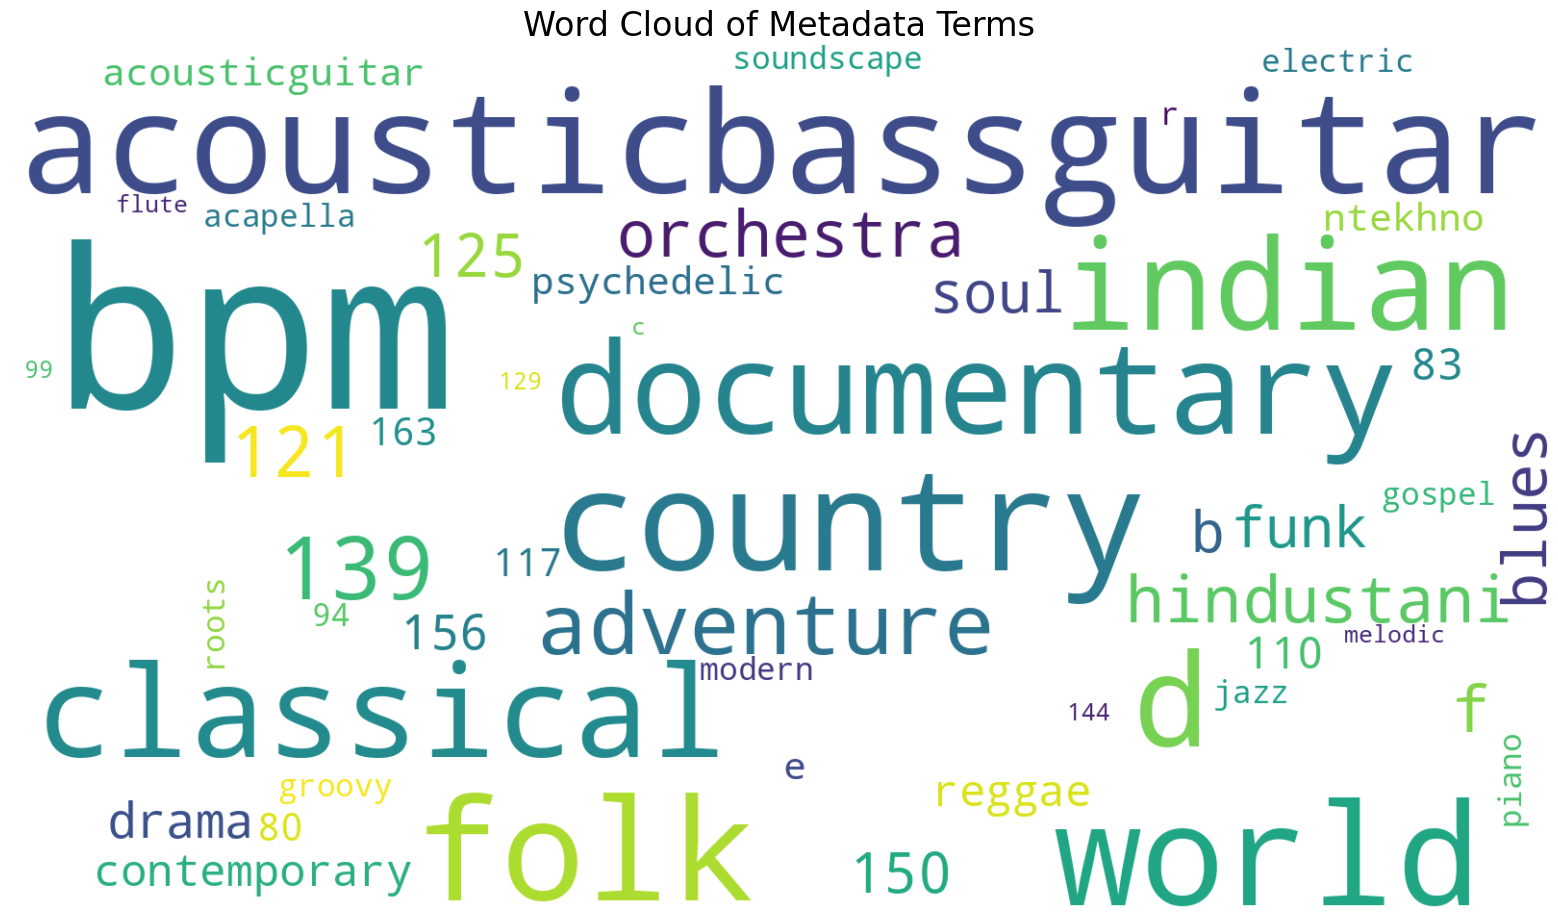


Total metadata entries: 70
Total words: 656
Unique words: 51
Word diversity ratio: 0.08


In [13]:
# Create a word cloud from metadata embeddings
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from collections import Counter

# Function to clean and tokenize text
def clean_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Collect all metadata text
all_metadata = []
for item in processed_metadata:
    metadata = item.get("metadata", "")
    if metadata:
        all_metadata.append(clean_text(metadata))

# Combine all text into one string
all_text = " ".join(all_metadata)

# Create word count
words = all_text.split()
word_counts = Counter(words)

# Remove common stopwords that might not be meaningful for your analysis
stopwords = {'and', 'the', 'to', 'in', 'of', 'with', 'a', 'is', 'for', 'on', 'by'}
for word in stopwords:
    if word in word_counts:
        del word_counts[word]

# Print the most common terms
print("Most common terms in metadata:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

# Create a word cloud
plt.figure(figsize=(16, 9))
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    background_color='white',
    max_words=150,
    colormap='viridis',
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Metadata Terms', fontsize=24)
plt.tight_layout(pad=0)

# Save the word cloud
output_dir = "analysis"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "metadata_wordcloud.png"), dpi=300)
plt.show()

# Print some statistics about the metadata
unique_words = len(word_counts)
total_words = sum(word_counts.values())
print(f"\nTotal metadata entries: {len(all_metadata)}")
print(f"Total words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Word diversity ratio: {unique_words/total_words:.2f}")

- The final dataset we used here comprises of Indian Classical Fusion music, which features traditional Indian instruments such as sitar, tabla, and mridangam with Western musical elements, including contemporary jazz and rock influences.

- From this word cloud, we see that the words "acousticbassguitar" and "documentary" is flagged as some of the most used words. Upon some analysis with other datasets we see that the "acousticbassguitar" usually points to the instrument "sitar" and "documentary" points to a type of music mood/style that the model is not familiar with, in this case that is Indian classical fusion. This could be due to the lack of diversity and lack of datasets in this specific type of music and genres.

- So we replace these words with more appropriate words for the current dataset that could help in training the model based on the features better.

In [15]:
# Replace specific terms in metadata and save as final processed dataset
import os
import re
from tqdm import tqdm
from datasets import Dataset

print("Original metadata examples:")
for i in range(3):  # Show a few examples before replacement
    print(f"Example {i+1}: {processed_metadata[i].get('metadata', 'No metadata')}")

# Function to replace terms in metadata
def replace_terms(text):
    if not isinstance(text, str):
        return text
    
    # Replace the terms
    text = re.sub(r'\bacousticbassguitar\b', 'sitar', text, flags=re.IGNORECASE)
    text = re.sub(r'\bdocumentary\b', 'fusion', text, flags=re.IGNORECASE)
    
    return text

# Create a map function to modify the metadata
def update_metadata(example):
    if "metadata" in example:
        example["metadata"] = replace_terms(example["metadata"])
    return example

# Use map() to create a new dataset with updated metadata
print("\nReplacing terms in metadata...")
final_processed_metadata = processed_metadata.map(
    update_metadata,
    desc="Updating metadata terms"
)

# Show examples after replacement
print("\nUpdated metadata examples:")
for i in range(3):  # Show the same examples after replacement
    print(f"Example {i+1}: {final_processed_metadata[i].get('metadata', 'No metadata')}")

# Count term occurrences in the updated dataset
print("\nCounting term occurrences in the updated dataset...")
acousticbassguitar_count = 0
documentary_count = 0
sitar_count = 0
fusion_count = 0

for i in range(len(final_processed_metadata)):
    metadata = final_processed_metadata[i].get("metadata", "").lower()
    if "acousticbassguitar" in metadata:
        acousticbassguitar_count += 1
    if "documentary" in metadata:
        documentary_count += 1
    if "sitar" in metadata:
        sitar_count += 1
    if "fusion" in metadata and "confusion" not in metadata:  # Avoid counting "confusion"
        fusion_count += 1

print(f"Term counts after replacement:")
print(f"- 'acousticbassguitar': {acousticbassguitar_count} (should be 0)")
print(f"- 'documentary': {documentary_count} (should be 0)")
print(f"- 'sitar': {sitar_count}")
print(f"- 'fusion': {fusion_count}")

# Save the updated dataset
output_dir = "processed_data/as-traes-updated-data"
os.makedirs(output_dir, exist_ok=True)
final_processed_metadata.save_to_disk(output_dir)

print(f"\n✅ Final processed metadata saved to: {output_dir}")
print(f"Total entries: {len(final_processed_metadata)}")

Original metadata examples:
Example 1: 121 bpm, documentary, acousticbassguitar, D, Folk, World, & Country, Hindustani
Example 2: orchestra, D, Folk, World, & Country, Indian Classical, 139 bpm, documentary
Example 3: documentary, orchestra, Folk, World, & Country, Indian Classical, 121 bpm, D#

Replacing terms in metadata...

Updated metadata examples:
Example 1: 121 bpm, fusion, sitar, D, Folk, World, & Country, Hindustani
Example 2: orchestra, D, Folk, World, & Country, Indian Classical, 139 bpm, fusion
Example 3: fusion, orchestra, Folk, World, & Country, Indian Classical, 121 bpm, D#

Counting term occurrences in the updated dataset...
Term counts after replacement:
- 'acousticbassguitar': 0 (should be 0)
- 'documentary': 0 (should be 0)
- 'sitar': 55
- 'fusion': 44


Saving the dataset (1/1 shards): 100%|██████████| 70/70 [00:00<00:00, 78.19 examples/s]


✅ Final processed metadata saved to: processed_data/as-traes-updated-data
Total entries: 70


In [16]:
processed_metadata = load_from_disk('processed_data/as-traes-updated-data')

### Word Cloud of Updated Metadata Terms


Most common terms in updated metadata:
bpm: 70
sitar: 55
folk: 55
world: 55
country: 55
d: 45
fusion: 44
classical: 44
indian: 43
139: 17
adventure: 16
121: 11
hindustani: 9
orchestra: 9
f: 9
125: 8
blues: 8
funk: 7
soul: 7
b: 7


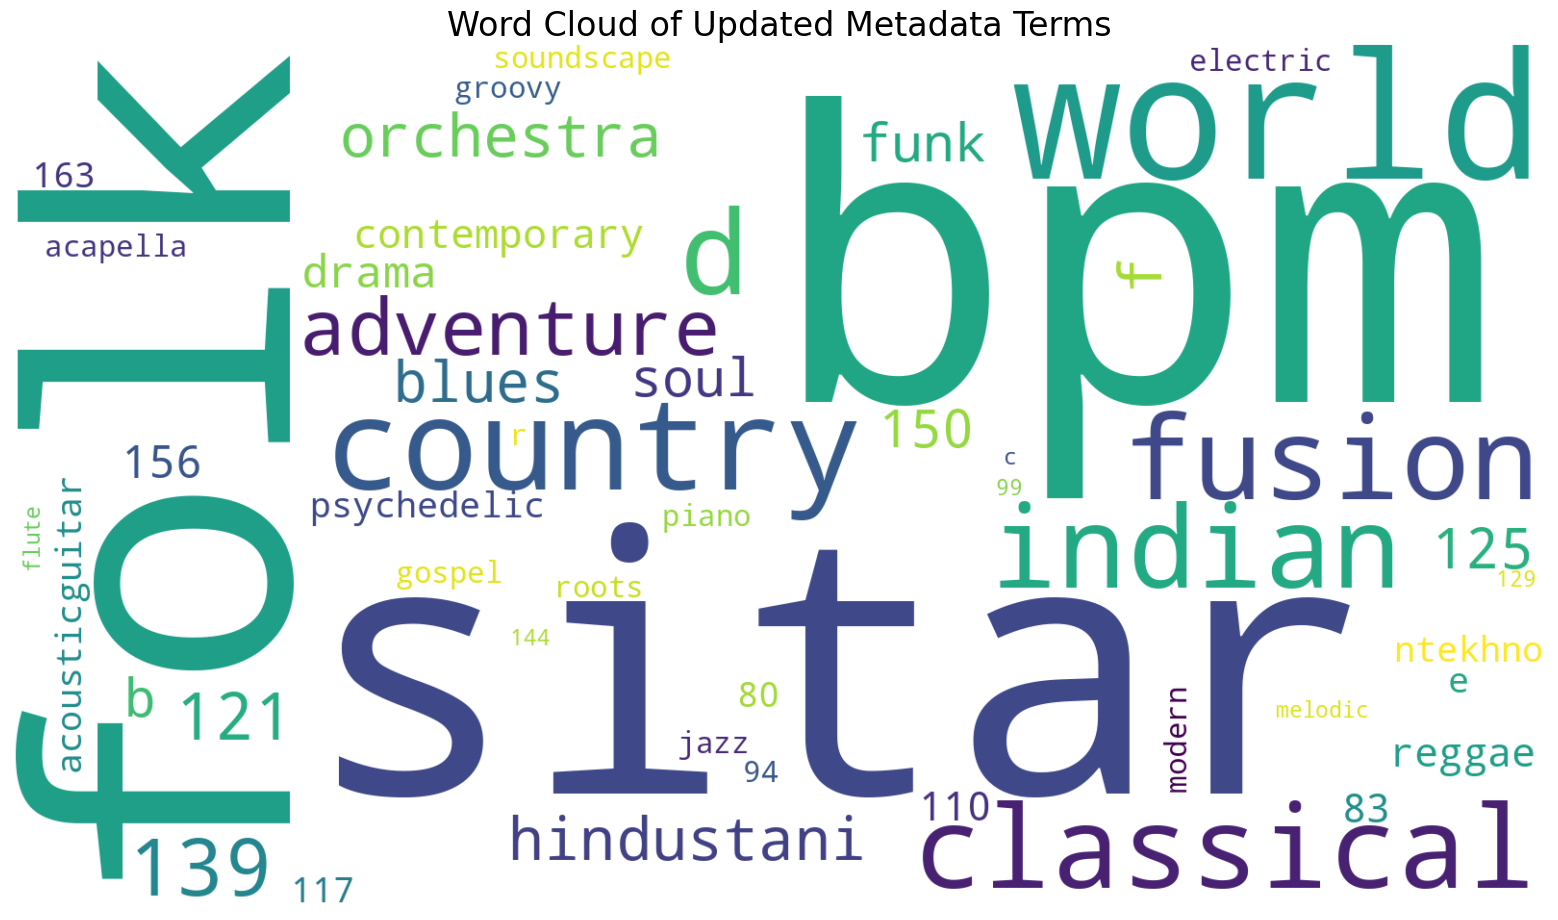


Total metadata entries: 70
Total words: 656
Unique words: 51
Word diversity ratio: 0.08


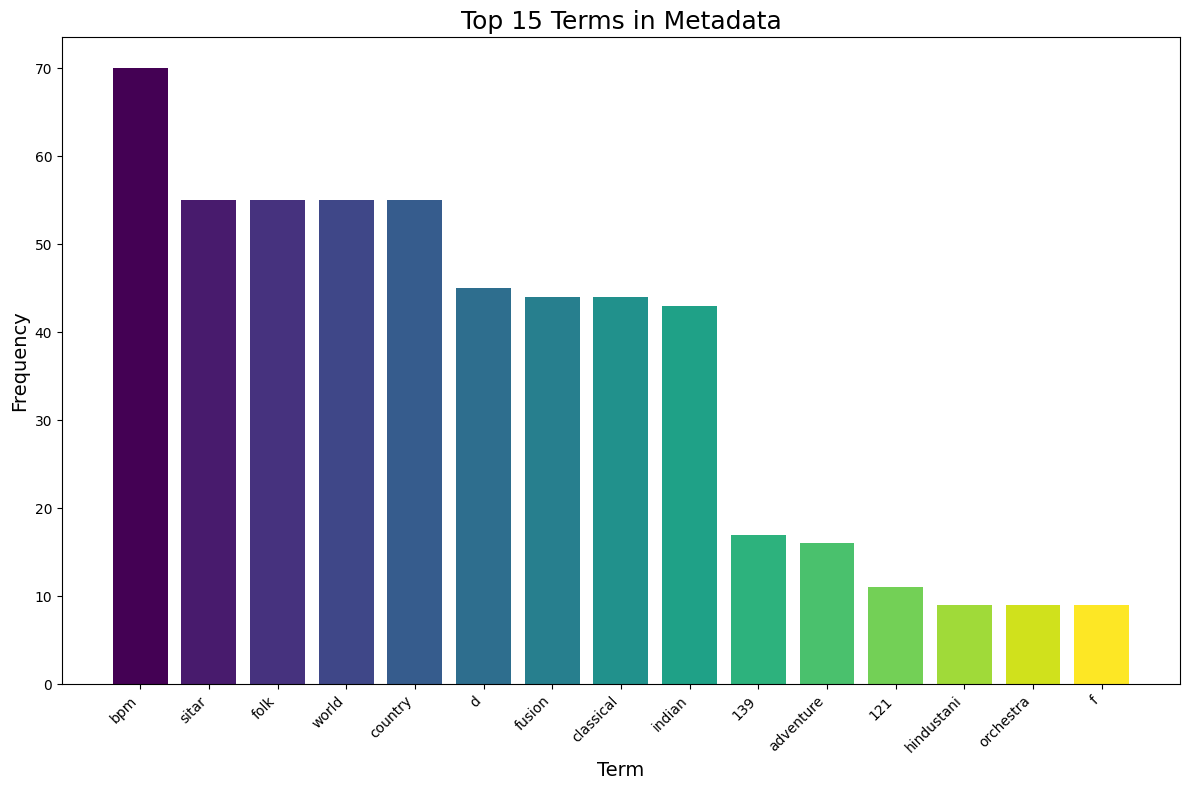

In [17]:
# Create a word cloud from updated metadata embeddings

# Collect all metadata text
all_metadata = []
print("Collecting metadata for word cloud...")
for i in range(len(processed_metadata)):
    metadata = processed_metadata[i].get("metadata", "")
    if metadata:
        all_metadata.append(clean_text(metadata))

# Combine all text into one string
all_text = " ".join(all_metadata)

# Create word count
words = all_text.split()
word_counts = Counter(words)

# Remove common stopwords
stopwords = {'and', 'the', 'to', 'in', 'of', 'with', 'a', 'is', 'for', 'on', 'by'}
for word in stopwords:
    if word in word_counts:
        del word_counts[word]

# Print the most common terms
print("\nMost common terms in updated metadata:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

# Create a word cloud
plt.figure(figsize=(16, 9))
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    background_color='white',
    max_words=150,
    colormap='viridis',
    contour_width=1,
    contour_color='steelblue',
    random_state=42
).generate_from_frequencies(word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Updated Metadata Terms', fontsize=24)
plt.tight_layout(pad=0)

# Save the word cloud
output_dir = "analysis"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "updated_metadata_wordcloud.png"), dpi=300)
plt.show()

# Print some statistics about the metadata
unique_words = len(word_counts)
total_words = sum(word_counts.values())
print(f"\nTotal metadata entries: {len(all_metadata)}")
print(f"Total words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Word diversity ratio: {unique_words/total_words:.2f}")

# Create a bar chart of the top terms
top_n = 15
top_terms = dict(word_counts.most_common(top_n))
plt.figure(figsize=(12, 8))
plt.bar(top_terms.keys(), top_terms.values(), color=plt.cm.viridis(np.linspace(0, 1, top_n)))
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} Terms in Metadata', fontsize=18)
plt.xlabel('Term', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "top_terms_bar_chart.png"), dpi=300)
plt.show()

# **Training**

We start by loading the processor, which handles tokenization, along with the MusicGen model we will be using. In this case, we are using [MusicGen-Melody](https://huggingface.co/facebook/musicgen-melody), a 1.5B parameter variant of MusicGen that supports conditioning on audio chroma.

In [ ]:
from transformers import (
    AutoProcessor,
    AutoModelForTextToWaveform,
)

# Load MusicGen's text-to-audio model and its processor
processor = AutoProcessor.from_pretrained("facebook/musicgen-melody")
model = AutoModelForTextToWaveform.from_pretrained("facebook/musicgen-melody")

# Freeze the encoders to focus training only on the decoder
model.freeze_text_encoder() 
model.freeze_audio_encoder() 

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


A small example as to how the MusicGen-melody model generates Indian Classical fusion music prior to any fine-tuning

In [14]:
from IPython.display import Audio
import torch

device = torch.device("cuda:0" if torch.cuda.device_count()>0 else "cpu")

model.to(device)

inputs = processor(
    text=["Indian classical fusion music with a fusion of western rock music. The music should have sitar playing the melody, electric guitar playing the chords and drums as the rhythm section."],
    padding=True,
    return_tensors="pt",
).to(device)

audio_values = model.generate(**inputs, do_sample=True, guidance_scale=3, max_new_tokens=256)


Audio(audio_values.cpu().numpy().squeeze(), rate=32000)

The following steps outline the preprocessing pipeline:

- Resample the audio samples if necessary to match the model’s requirements.

- Add an instance prompt—an anchor term that guides the model toward learning a specific feature. In this case, we are using "Indian classical fusion" to help the model specialize in generating music based on our dataset.

- Tokenize the textual music descriptions.

- Encode the audio samples using Encodec for further processing.

In [19]:
from transformers import AutoFeatureExtractor
from datasets import Audio

instance_prompt = "Indian classical fusion anoushka shankar"
# take audio_encoder_feature_extractor
audio_encoder_feature_extractor = AutoFeatureExtractor.from_pretrained(
    model.config.audio_encoder._name_or_path,
)

# resample audio if necessary
dataset_sampling_rate = processed_metadata[0]["audio"]["sampling_rate"]

if dataset_sampling_rate != audio_encoder_feature_extractor.sampling_rate:
    processed_metadata = processed_metadata.cast_column(
        "audio",
        Audio(
            sampling_rate=audio_encoder_feature_extractor.sampling_rate
        ),
    )

# Preprocessing the datasets.
# We need to read the audio files as arrays and tokenize the targets.
def prepare_audio_features(batch):
    # load audio
    metadata = batch["metadata"]
    metadata = f"{instance_prompt}, {metadata}"
    batch["input_ids"] = processor.tokenizer(metadata)["input_ids"]

    # load audio
    target_sample = batch["audio"]
    labels = audio_encoder_feature_extractor(
        target_sample["array"], sampling_rate=target_sample["sampling_rate"]
    )
    batch["labels"] = labels["input_values"]

    # take length of raw audio waveform
    batch["target_length"] = len(target_sample["array"].squeeze())
    return batch

# preprocess datasets (setting dataset as the training dataset)
dataset = processed_metadata.map(
    prepare_audio_features,
    remove_columns=processed_metadata.column_names,
    num_proc=2,
    desc="preprocess datasets",
)

preprocess datasets (num_proc=2): 100%|██████████| 70/70 [00:02<00:00, 30.32 examples/s] 


In [20]:
audio_decoder = model.audio_encoder
num_codebooks = model.decoder.config.num_codebooks
audio_encoder_pad_token_id = model.config.decoder.pad_token_id

pad_labels = torch.ones((1, 1, num_codebooks, 1)) * audio_encoder_pad_token_id

if torch.cuda.device_count() == 1:
    audio_decoder.to("cuda")

def apply_audio_decoder(batch):

    with torch.no_grad():
        labels = audio_decoder.encode(
            torch.tensor(batch["labels"]).to(audio_decoder.device)
        )["audio_codes"]

    # add pad token column
    labels = torch.cat(
        [pad_labels.to(labels.device).to(labels.dtype), labels], dim=-1
    )

    labels, delay_pattern_mask = model.decoder.build_delay_pattern_mask(
        labels.squeeze(0),
        audio_encoder_pad_token_id,
        labels.shape[-1] + num_codebooks,
    )

    labels = model.decoder.apply_delay_pattern_mask(labels, delay_pattern_mask)

    # the first timestamp is associated to a row full of BOS, let's get rid of it
    batch["labels"] = labels[:, 1:].cpu()
    return batch

# Encodec doesn't truely support batching
# Pass samples one by one to the GPU
dataset = dataset.map(
    apply_audio_decoder,
    num_proc=1,
    desc="Apply encodec",
)

Parameter 'function'=<function apply_audio_decoder at 0x7f1d02142dd0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Apply encodec: 100%|██████████| 70/70 [00:57<00:00,  1.22 examples/s]


We'll also add the [LoRA adaptors](https://huggingface.co/docs/peft/en/developer_guides/lora) on top of the model, thanks to [PEFT](https://huggingface.co/docs/peft). This is what will allow to train fast and with low GPU resources!



In [ ]:
from peft import LoraConfig, get_peft_model

# Define which layers will receive LoRA adapters
target_modules = (
    [
        "enc_to_dec_proj",
        "audio_enc_to_dec_proj",
        "k_proj",
        "v_proj",
        "q_proj",
        "out_proj",
        "fc1",
        "fc2",
        "lm_heads.0",
    ]
    + [f"lm_heads.{str(i)}" for i in range(len(model.decoder.lm_heads))]
    + [f"embed_tokens.{str(i)}" for i in range(len(model.decoder.lm_heads))]
)

# Configure LoRA (Low-Rank Adaptation) parameters
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
)
# Enable gradient computation for input embeddings
model.enable_input_require_grads()

# Apply LoRA configuration to the model
model = get_peft_model(model, config)

# Display info about trainable vs. frozen parameters
model.print_trainable_parameters()

trainable params: 21,754,112 || all params: 1,577,038,658 || trainable%: 1.3794


There's two last steps to do before finally move to training !

1. Define the Trainer, i.e the class that will take care of the training under-the-hood.
2. Define a collator, i.e a class that will pass samples to the GPU.


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from dataclasses import dataclass

# Custom trainer class that overrides padding behavior for MusicGen's multi-codebook outputs
class MusicgenTrainer(Seq2SeqTrainer):
    def _pad_tensors_to_max_len(self, tensor, max_length):
        # Determine which padding token to use
        if self.tokenizer is not None and hasattr(self.tokenizer, "pad_token_id"):
            pad_token_id = (
                self.tokenizer.pad_token_id
                if self.tokenizer.pad_token_id is not None
                else self.tokenizer.eos_token_id
            )
        else:
            if self.model.config.pad_token_id is not None:
                pad_token_id = self.model.config.pad_token_id
            else:
                raise ValueError(
                    "Pad_token_id must be set in the configuration of the model, in order to pad tensors"
                )

        # Create padded tensor and copy original content
        padded_tensor = pad_token_id * torch.ones(
            (tensor.shape[0], max_length, tensor.shape[2]),
            dtype=tensor.dtype,
            device=tensor.device,
        )
        length = min(max_length, tensor.shape[1])
        padded_tensor[:, :length] = tensor[:, :length]
        return padded_tensor


# Custom data collator to handle MusicGen's special padding requirements
@dataclass
class DataCollatorMusicGenWithPadding:
    processor: AutoProcessor

    def __call__(self, features):
        # Handle audio codebook labels (needs special 3D padding)
        labels = [
            torch.tensor(feature["labels"]).transpose(0, 1) for feature in features
        ]
        labels = torch.nn.utils.rnn.pad_sequence(
            labels, batch_first=True, padding_value=-100
        )

        # Handle text input ids (using standard tokenizer padding)
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        input_ids = self.processor.tokenizer.pad(input_ids, return_tensors="pt")

        # Combine into final batch
        batch = {"labels": labels, **input_ids}
        return batch

# Create collator instance
data_collator = DataCollatorMusicGenWithPadding(
    processor=processor,
)

In [ ]:
## Training arguments
training_args = Seq2SeqTrainingArguments(
      output_dir="./models/as-traes-updated/",
      num_train_epochs=3,
      gradient_accumulation_steps=16,
      gradient_checkpointing=True,
      per_device_train_batch_size= 1,
      learning_rate=2e-4,
      weight_decay=0.1,
      adam_beta2=0.99,
      fp16=True,
      dataloader_num_workers=1,
      logging_steps=5,
      report_to="none",   
      save_steps=20,                 
      eval_steps=20,
      push_to_hub=True,
      push_to_hub_model_id="musicgen-melody-lora-indian-classical-fusion-as-traes-updated",
)


# LoRA is enabled with minimal rank for more optimization
lora_config = LoraConfig(
    r=8,                    # Reduced rank
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
)

# Initialize MusicgenTrainer
trainer = MusicgenTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    tokenizer=processor,
)

train_result = trainer.train()

trainer.save_model()
trainer.save_state()


kwargs = {
    "finetuned_from": "facebook/musicgen-melody",
    "tasks": "text-to-audio",
    "tags": ["text-to-audio", "indian-fusion-as-traes-updated"],
    "dataset": "MadJ99/indian-fusion",
}

trainer.push_to_hub(**kwargs)
